## import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd # table operations
import numpy as np # linear algebra
import seaborn as sns # visualizing
import os # getting path
from sklearn.utils import shuffle
import matplotlib.pyplot as plt # visualizing
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # prepare image
import cv2 # haar cascade
from scipy.spatial import distance
import glob
from warnings import filterwarnings
from tensorflow.keras.applications import VGG19 # classify modle
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint # save best model weights
from tensorflow.keras.models import Model, load_model # load model
from sklearn.metrics import confusion_matrix
from skimage import io
filterwarnings("ignore")

In [ ]:
path  = "/content/drive/MyDrive/Face_mask/"

In [ ]:
dataset = {"image_path":[],"mask_status":[],"where":[]}
for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset

,image_path,mask_status,where
0,/content/drive/MyDrive/Face_mask/Validation/Wi...,WithoutMask,Validation
1,/content/drive/MyDrive/Face_mask/Validation/Wi...,WithoutMask,Validation
2,/content/drive/MyDrive/Face_mask/Validation/Wi...,WithoutMask,Validation
3,/content/drive/MyDrive/Face_mask/Validation/Wi...,WithoutMask,Validation
4,/content/drive/MyDrive/Face_mask/Validation/Wi...,WithoutMask,Validation
...,...,...,...
11787,/content/drive/MyDrive/Face_mask/Test/WithMask...,WithMask,Test
11788,/content/drive/MyDrive/Face_mask/Test/WithMask...,WithMask,Test
11789,/content/drive/MyDrive/Face_mask/Test/WithMask...,WithMask,Test
11790,/content/drive/MyDrive/Face_mask/Test/WithMask...,WithMask,Test


In [ ]:
dataset.value_counts("mask_status")

mask_status
WithoutMask    5909
WithMask       5883
dtype: int64

With Mask: 5883,
Without Mask: 5909



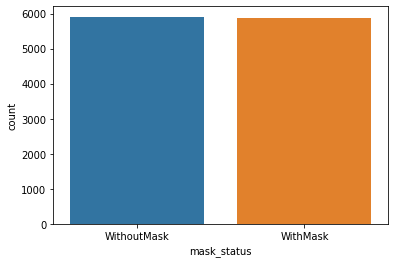

In [ ]:
mask = dataset.value_counts("mask_status")[1]
withoutmask = dataset.value_counts("mask_status")[0]

print(f"With Mask: {mask},\nWithout Mask: {withoutmask}\n")
sns.countplot(dataset["mask_status"])
plt.show()

In [ ]:
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

In [ ]:
train_df = train_df.sample(frac=1)   # this is basically used to shuffle the dataset
test_df = test_df.sample(frac=1)
valid_df = valid_df.sample(frac=1)


In [ ]:
train_df.head()

,image_path,mask_status,where
9081,/content/drive/MyDrive/Face_mask/Train/WithMas...,WithMask,Train
10620,/content/drive/MyDrive/Face_mask/Train/WithMas...,WithMask,Train
10088,/content/drive/MyDrive/Face_mask/Train/WithMas...,WithMask,Train
815,/content/drive/MyDrive/Face_mask/Train/Without...,WithoutMask,Train
8262,/content/drive/MyDrive/Face_mask/Train/WithMas...,WithMask,Train


In [ ]:
test_df.head()

,image_path,mask_status,where
11203,/content/drive/MyDrive/Face_mask/Test/WithoutM...,WithoutMask,Test
10988,/content/drive/MyDrive/Face_mask/Test/WithoutM...,WithoutMask,Test
11561,/content/drive/MyDrive/Face_mask/Test/WithMask...,WithMask,Test
11743,/content/drive/MyDrive/Face_mask/Test/WithMask...,WithMask,Test
11019,/content/drive/MyDrive/Face_mask/Test/WithoutM...,WithoutMask,Test


In [ ]:
valid_df.head()

,image_path,mask_status,where
53,/content/drive/MyDrive/Face_mask/Validation/Wi...,WithoutMask,Validation
157,/content/drive/MyDrive/Face_mask/Validation/Wi...,WithoutMask,Validation
647,/content/drive/MyDrive/Face_mask/Validation/Wi...,WithMask,Validation
310,/content/drive/MyDrive/Face_mask/Validation/Wi...,WithoutMask,Validation
304,/content/drive/MyDrive/Face_mask/Validation/Wi...,WithoutMask,Validation


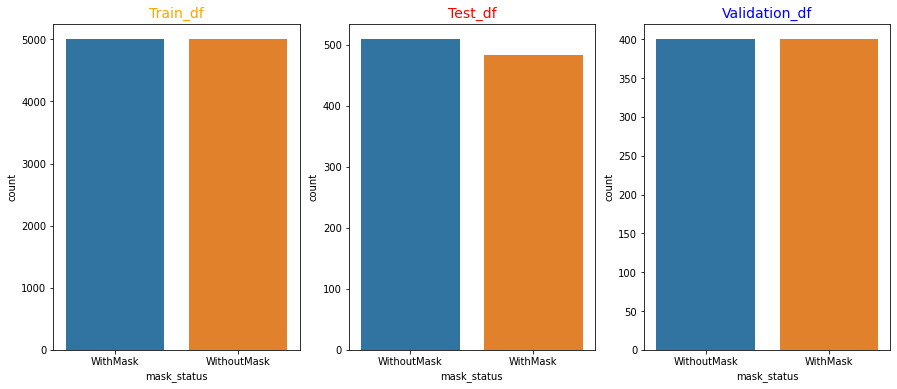

In [ ]:
plt.figure(figsize = (15,6))
plt.subplot(1,3,1)
sns.countplot(train_df["mask_status"])
plt.title("Train_df", size = 14, color = "orange")


plt.subplot(1,3,2)
sns.countplot(test_df["mask_status"])
plt.title("Test_df", size = 14, color = "red")


plt.subplot(1,3,3)
sns.countplot(valid_df["mask_status"])
plt.title("Validation_df", size = 14, color = "blue")

plt.show()

## Preprocessing image 

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory="../input",
x_col="image_path",
y_col="mask_status",
batch_size=80,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

Found 10000 validated image filenames belonging to 2 classes.


In [ ]:
valid_generator=datagen.flow_from_dataframe(
dataframe=valid_df,
directory="../input",
x_col="image_path",
y_col="mask_status",
batch_size=80,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

Found 800 validated image filenames belonging to 2 classes.


In [ ]:
test_generator=datagen.flow_from_dataframe(
dataframe=test_df,
directory="../input",
x_col="image_path",
y_col="mask_status",
batch_size=80,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(150,150))

Found 992 validated image filenames belonging to 2 classes.


## Classify Model

In [ ]:
model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in model.layers[2:]: 
  layer.trainable = False
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
x=Flatten()(model.output)
x2 = Dense(128, activation="relu")(x)
output=Dense(1,activation='sigmoid')(x2) # 
model=Model(model.input,output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# save best weights
checkpoint = ModelCheckpoint("classify_model.h5", save_best_only=True, verbose = 1)

In [ ]:
model.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])
history = model.fit_generator(train_generator,validation_data  = valid_generator, epochs = 5, steps_per_epoch=(len(train_generator.labels) / 80) ,validation_steps=(len(valid_generator.labels)/80), callbacks =[checkpoint])

Epoch 1/5
125/125 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9578 
Epoch 00001: val_loss improved from inf to 0.00821, saving model to classify_model.h5
125/125 [==============================] - 2038s 16s/step - loss: 0.1168 - accuracy: 0.9578 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 2/5
125/125 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9970
Epoch 00002: val_loss improved from 0.00821 to 0.00756, saving model to classify_model.h5
125/125 [==============================] - 106s 847ms/step - loss: 0.0117 - accuracy: 0.9970 - val_loss: 0.0076 - val_accuracy: 0.9987
Epoch 3/5
125/125 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9987
Epoch 00003: val_loss improved from 0.00756 to 0.00585, saving model to classify_model.h5
125/125 [==============================] - 106s 844ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.0058 - val_accuracy: 0.9987
Epoch 4/5
125/125 [=========================

In [ ]:
# load model
model = load_model("classify_model.h5")

In [ ]:
model.evaluate_generator(test_generator, verbose=1)

13/13 [==============================] - 199s 16s/step - loss: 0.0151 - accuracy: 0.9990


[0.015123040415346622, 0.9989919066429138]

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Model evaluation

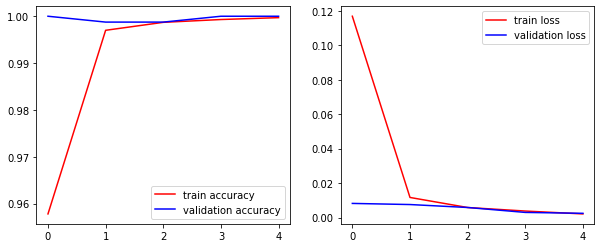

In [ ]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label = "train accuracy", color = "red")
plt.plot(history.history["val_accuracy"], label = "validation accuracy", color = "blue")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label = "train loss", color = "red")
plt.plot(history.history["val_loss"], label = "validation loss", color = "blue")

plt.legend()
plt.show()

In [ ]:
predictions = model.predict_generator(test_generator, verbose = 1,workers=-1)

13/13 [==============================] - 8s 591ms/step


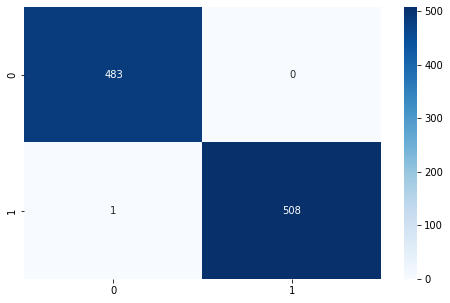

In [ ]:
plt.figure(figsize = (8,5))
sns.heatmap(confusion_matrix(test_generator.labels, predictions.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report,roc_curve,auc
target_names = ['With Mask','Without Mask']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_results():
  roc_acc = roc_auc_score(test_generator.labels, predictions)
  print('> ROC Accuracy: {}'.format(roc_acc.round(4)))
print_results()

> ROC Accuracy: 0.9989


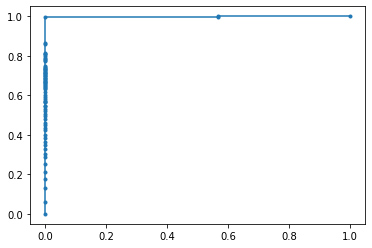

In [ ]:
nn_fpr, nn_tpr, nn_thresholds = roc_curve(test_generator.labels, predictions)
auc_keras = auc(nn_fpr, nn_tpr)
plt.plot(nn_fpr, nn_tpr, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)